# Introduction

In this tutorial I will walk you through some of the basic steps in the data cleaning process, explore the data, generate some visualizations, and finally save our cleaned dataset for future use.   

### The Data
The dataset we will be using is one provided for public use by the Capital Bikeshare program in Washington D.C (https://www.capitalbikeshare.com/system-data). The dataset contains information on daily trips taken with a Capital Bikeshare bike from the program's inception on January 1st, 2011 until December 31st, 2012. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#prevents warnings when plotting datetimes
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv('BSS_hour_raw.csv')

The first thing I always do is use the head method on our dataset, just to ensure that everything was loaded properly and begin to get a sense of what kind of data we are working with. 

In [3]:
data.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


Excellent. We see that everything seems to have been loaded properly and that we are working with 13 variables. However, just calling 'head' doesn't offer much more information than a quick glance. Next let's use a couple of the datasets *attributes* to learn a little bit more about the data. 

In [4]:
data.shape

(17379, 13)

The shape of our dataset (i.e. the number of rows and columns present) shows us that we have over 17000 datapoints. 

In [5]:
data.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

From the dtypes (i.e. datatypes) we can see that all of the numerical variables are correctly typed, however, the dteday variable seems to be represented as a string. Since we will be doing some analysis based on the day, it's best that we turn the dteday variable into a datetime index. 

In [6]:
data.dteday = pd.DatetimeIndex(data.dteday)

In [7]:
data.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

Great. Now we can see that the dtedate column is a datetime type. Now let's do some basic visualizations of the data. We will start by plotting the number of total rides per day (i.e. the casual riders *and* the registered riders). First, let's create a new column and save it in our dataframe. 

In [8]:
data.dteday.min(), data.dteday.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 00:00:00'))

There are a million different analyses we could dive into here, but to keep things simple we will only look at how ridership is affected by the season. Which means is that we fill first have to combine the 'casual' and 'registered' columns into one *total rides* column. 

In [9]:
data['total_rides'] = data.casual + data.registered

In [10]:
data.dteday.head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

Now if our data were already organized into one-day-per-row then plotting would be straightforward. However, as we we can see above, there are many datapoints for each day. In fact, let's view a little more of our dataset to get a better feel for what we have. 

In [11]:
data['hour'].head(25)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24     0
Name: hour, dtype: int64

We can see here that there are 24 datapoints per day, corresponding to each hour in that day. First let's simply group our data by day, aggregate the total rides, and visualize how the number of riders changes with the seasons. 

In [12]:
day_group = data.groupby('dteday')

In [13]:
all_rides = day_group.aggregate({'total_rides': sum, 'season':max})

In [14]:
all_rides.head()

,total_rides,season
dteday,,
2011-01-01,985,1
2011-01-02,801,1
2011-01-03,1349,1
2011-01-04,1562,1
2011-01-05,1600,1


In [42]:
data.groupby('season').agg({'total_rides':sum})

,total_rides
season,
Fall,841613
Spring,918589
Summer,1061129
Winter,471348


Just from this basic groupby aggregation, we can see that the Summer clearaly has the most rides, while Winter has the fewest. 

But a simple table doesn't quite convey the same information as a plot.

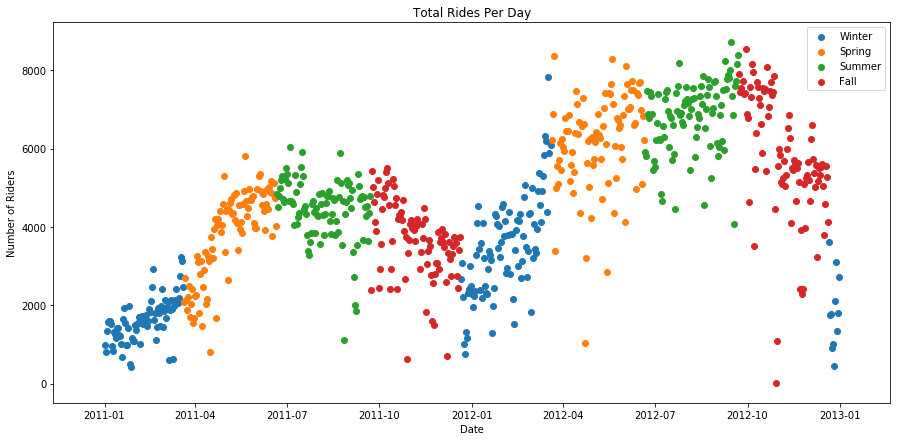

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
mapper = {1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'}
for season in all_rides.season.unique():
    subset = all_rides[all_rides.season==season]
    ax.scatter(subset.index, subset.total_rides, label=mapper[season])
    
ax.set_title('Total Rides Per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Riders')
ax.legend()

As we can see above there are some visual differences between the number of rides that take place across seasons, which makes sense, who wants to ride a bike in the middle of winter? 

Let's look into that a little bit more.

In [16]:
data.season.replace({1:'Winter',2:'Spring',3:'Summer',4:'Fall'}, inplace=True)

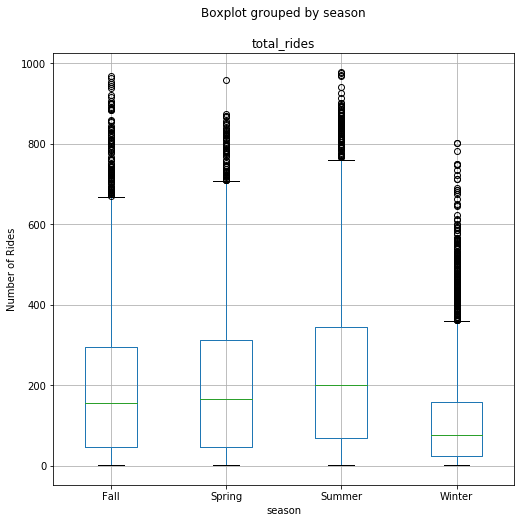

In [17]:
fig, ax = plt.subplots(figsize=(8,8))

data.boxplot(column='total_rides', by='season', ax=ax)
ax.set_ylabel('Number of Rides');

This plot doesn't appear to paint the full picture. The colored scatter plot shows a general increasing trend across the years, which may be washing out the differences between the seasons. Let's introduce a 'year' variable and take year into account for our next boxplot. 

In [18]:
data['year'] = pd.DatetimeIndex(data.dteday).year

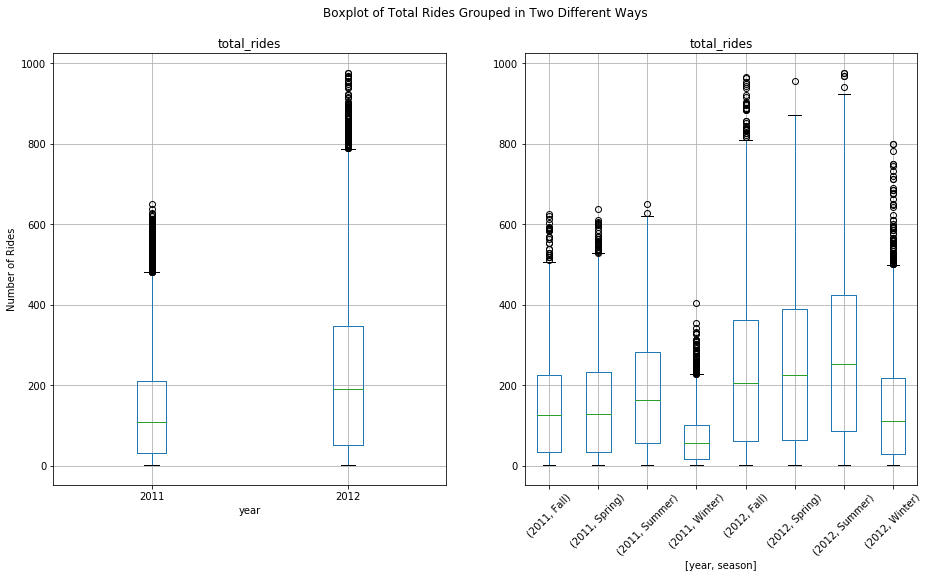

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

data.boxplot(column='total_rides', by='year', ax=ax[0])
data.boxplot(column='total_rides', by=['year', 'season'], ax=ax[1], rot=45) # add rot argument for rotating xticklabels
ax[0].set_ylabel('Number of Rides');
fig.suptitle('Boxplot of Total Rides Grouped in Two Different Ways');

Here we can see that there is indeed an increase in the average number of rides between years, which is represented in an increase in average ridership per season across years as well.  

Now let's see if we can't get a better idea of what time people are riding their bikes. We will make two plots which display largely the same information: a boxplot grouped by hour and the average number of rides per hour along with some 95% confidence intervals. 

In [20]:
by_hour = data.groupby('hour').agg(['mean','std'])
by_hour.head()

holiday             weekday           workingday             weather  \
          mean       std      mean       std       mean       std      mean   
hour                                                                          
0     0.028926  0.167713  3.004132  2.007224   0.683196  0.465551  1.398072   
1     0.029006  0.167938  3.008287  2.008264   0.682320  0.465896  1.400552   
2     0.029371  0.168961  3.027972  2.007493   0.681119  0.466369  1.409790   
3     0.025825  0.158727  3.027260  2.029411   0.674319  0.468965  1.424677   
4     0.028694  0.167066  3.011478  2.020693   0.674319  0.468965  1.426112   

                    temp            ... windspeed               casual  \
           std      mean       std  ...      mean       std       mean   
hour                                ...                                  
0     0.619184  0.467410  0.176550  ...  0.161758  0.109649  10.158402   
1     0.630966  0.459365  0.176498  ...  0.158659  0.112785   6.504144   
2     0.631715  0.454573  0.174807  ...  0.154519  0.113041   4.772028   
3     0.632337  0.453113  0.172499  ...  0.150929  0.110164   2.715925   
4     0.639285  0.446628  0.171371  ...  0.155813  0.110902   1.253945   

                registered            total_rides                    year  \
            std       mean        std        mean        std         mean   
hour                                                                        
0     10.667953  43.739669  34.019585   53.898072  42.307910  2011.502755   
1      7.735334  26.871547  27.344153   33.375691  33.538727  2011.502762   
2      6.514780  18.097902  21.303895   22.869930  26.578642  2011.507692   
3      4.315795   9.011478   9.743691   11.727403  13.239190  2011.509326   
4      1.887669   5.098996   3.134479    6.352941   4.143818  2011.516499   

                
           std  
hour            
0     0.500337  
1     0.500338  
2     0.500291  
3     0.500272  
4     0.500087  

[5 rows x 24 columns]

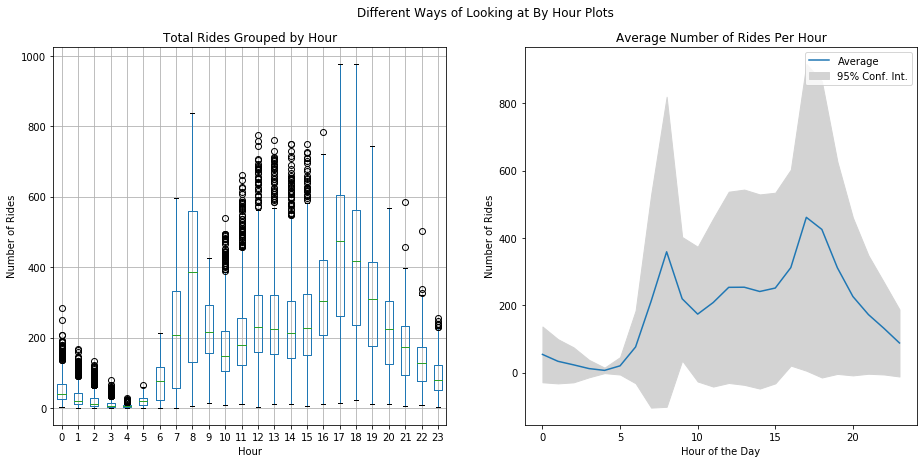

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

data.boxplot(column='total_rides', by='hour', ax=ax[0])
ax[0].set_ylabel('Number of Rides')
ax[0].set_xlabel('Hour')
ax[0].set_title('Total Rides Grouped by Hour')

upper = by_hour['total_rides']['mean'] + by_hour['total_rides']['std'] * 1.96
lower = by_hour['total_rides']['mean'] - by_hour['total_rides']['std'] * 1.96

ax[1].fill_between(by_hour.index, upper, lower, color='lightgrey', label='95% Conf. Int.')
ax[1].plot(by_hour.index, by_hour['total_rides']['mean'], label='Average')
ax[1].set_xlabel('Hour of the Day')
ax[1].set_ylabel('Number of Rides')
ax[1].set_title('Average Number of Rides Per Hour')
fig.suptitle('Different Ways of Looking at By Hour Plots')
ax[1].legend(); 

Perhaps the high variablility in our data can be attributed to the change in season. Let's create four separate scatter plots to show the differences in season.

In [22]:
season_hour = data.groupby(['season', 'hour']).agg(['mean', 'std'])
season_hour.head()

holiday             weekday           workingday            \
                 mean       std      mean       std       mean       std   
season hour                                                                
Fall   0     0.033898  0.181481  2.971751  2.012544   0.677966  0.468581   
       1     0.034091  0.181980  2.982955  2.012743   0.676136  0.469284   
       2     0.034286  0.182484  2.994286  2.012881   0.674286  0.469986   
       3     0.034682  0.183504  2.971098  2.027221   0.670520  0.471389   
       4     0.034091  0.181980  2.982955  2.012743   0.676136  0.469284   

              weather                temp            ... windspeed            \
                 mean       std      mean       std  ...      mean       std   
season hour                                          ...                       
Fall   0     1.361582  0.597622  0.398757  0.113661  ...  0.141335  0.111292   
       1     1.397727  0.614859  0.390227  0.115060  ...  0.150787  0.120948   
       2     1.428571  0.610526  0.384114  0.114977  ...  0.138854  0.117001   
       3     1.462428  0.633401  0.378497  0.113957  ...  0.135193  0.112622   
       4     1.471591  0.658387  0.372955  0.115873  ...  0.148667  0.114430   

               casual           registered            total_rides             \
                 mean       std       mean        std        mean        std   
season hour                                                                    
Fall   0     7.887006  8.567824  48.446328  36.888017   56.333333  43.733525   
       1     5.573864  6.764208  30.346591  30.805181   35.920455  36.609202   
       2     4.251429  5.834370  19.514286  22.909331   23.765714  27.530067   
       3     2.387283  3.698721   9.473988  10.815346   11.861272  13.825884   
       4     1.272727  1.735197   5.994318   2.801014    7.267045   3.487487   

                    year            
                    mean       std  
season hour                         
Fall   0     2011.497175  0.501410  
       1     2011.494318  0.501394  
       2     2011.497143  0.501427  
       3     2011.491329  0.501376  
       4     2011.494318  0.501394  

[5 rows x 24 columns]

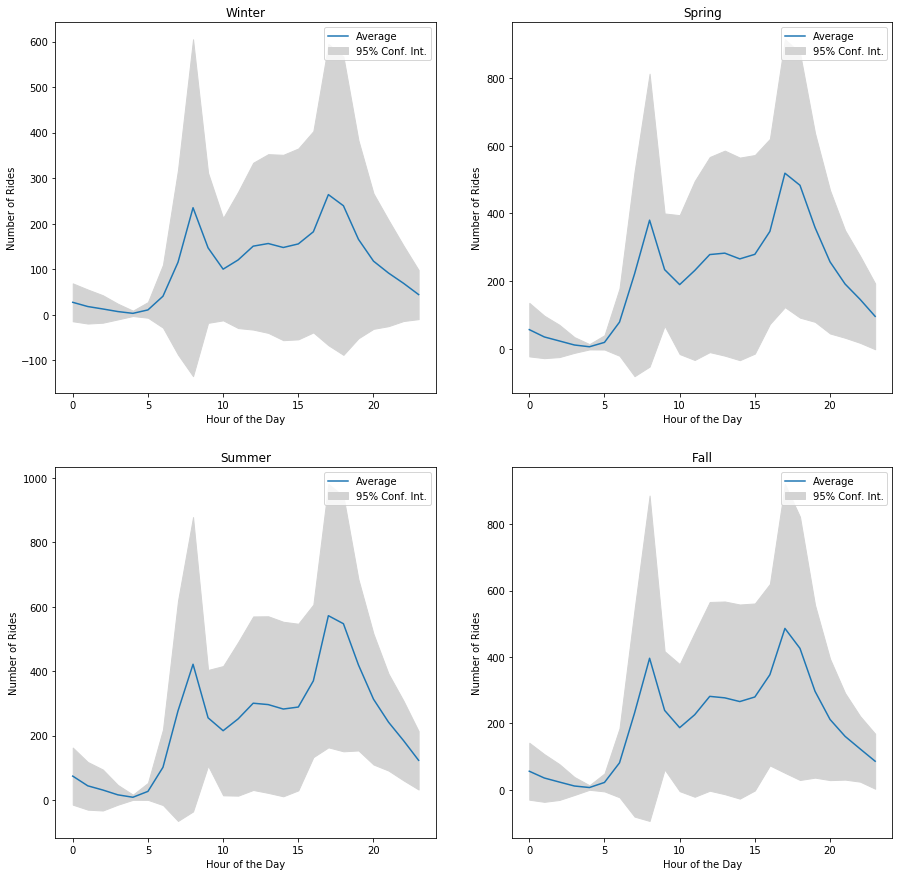

In [44]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

# each plot needs only the season, then plot each hour's average
s = ['Winter', 'Spring', 'Summer', 'Fall']
ax = ax.ravel() # simply 'unwinds' our array of ax objects: ax.shape==(2,2) --> ax.shape(4,)

for i in range(len(ax)):
    df = season_hour.loc[s[i],]
    upper = df['total_rides']['mean'] + df['total_rides']['std'] * 1.96
    lower = df['total_rides']['mean'] - df['total_rides']['std'] * 1.96

    ax[i].fill_between(df.index, upper, lower, color='lightgrey', label='95% Conf. Int.')
    ax[i].plot(df.index, df['total_rides']['mean'], label='Average')
    ax[i].set_xlabel('Hour of the Day')
    ax[i].set_ylabel('Number of Rides')
    ax[i].set_title(s[i])
    ax[i].legend();
    

At first blush there doesn't appear to be *any* difference between ridership and season. However, we must note that matplotlib took the liberty of scaling the y-axis for each plot to fit the data. Since we are interested in observing these differences, let's force the y-axis for each plot to the same scale. Additionally, we will limit the y-axis to 0, since it's not possible to have negative ridership in any given hour.

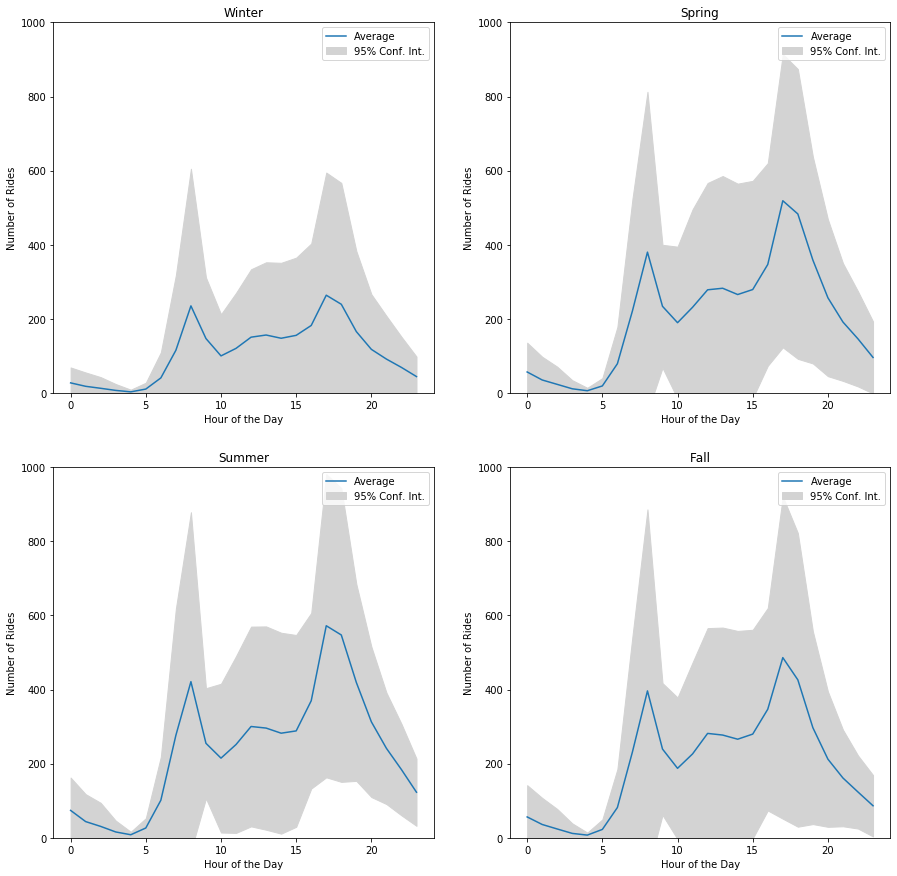

In [45]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

# each plot needs only the season, then plot each hour's average
s = ['Winter', 'Spring', 'Summer', 'Fall']
ax = ax.ravel()

for i in range(len(ax)):
    df = season_hour.loc[s[i],]
    upper = df['total_rides']['mean'] + df['total_rides']['std'] * 1.96
    lower = df['total_rides']['mean'] - df['total_rides']['std'] * 1.96

    ax[i].fill_between(df.index, upper, lower, color='lightgrey', label='95% Conf. Int.')
    ax[i].plot(df.index, df['total_rides']['mean'], label='Average')
    ax[i].set_xlabel('Hour of the Day')
    ax[i].set_ylabel('Number of Rides')
    ax[i].set_title(s[i])
    ax[i].set_ylim([-0,1000])
    ax[i].legend();


The last thing we will do here is combine the dteday column and the hour column into a singular combined time column. This will asssit us down the line with time series analysis.

In [28]:
data.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,total_rides,year
0,2011-01-01,Winter,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011
1,2011-01-01,Winter,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011
2,2011-01-01,Winter,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011
3,2011-01-01,Winter,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011
4,2011-01-01,Winter,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011


In [31]:
data.dtypes

dteday         datetime64[ns]
season                 object
hour                    int64
holiday                 int64
weekday                 int64
workingday              int64
weather                 int64
temp                  float64
atemp                 float64
hum                   float64
windspeed             float64
casual                  int64
registered              int64
total_rides             int64
year                    int64
dtype: object

In [39]:
data['time_combined'] = data.dteday + data.hour.apply(lambda x: pd.Timedelta(pd.offsets.Hour(x)))
data.dtypes

dteday           datetime64[ns]
season                   object
hour                      int64
holiday                   int64
weekday                   int64
workingday                int64
weather                   int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
total_rides               int64
year                      int64
time_combined    datetime64[ns]
dtype: object

In [40]:
# finally, we will save our data file in it's cleaned form for future use
data.to_csv('cleaned_bikes.csv')

## Conclusion

That just about does it. We've taken a peak at our data, quantified the affect of the season on ridership, visuzlized the results, and saved our cleaned file for use later on. 